In [82]:
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
import numpy as np
import pandas as pd


PROJECT_ROOT = Path.cwd().parent
EMB_DIR = PROJECT_ROOT / "models" / "embeddings"

X = np.load(EMB_DIR / "job_embeddings.npy")
meta = pd.read_parquet(EMB_DIR / "job_embeddings_meta.parquet")

X.shape, meta.shape

((123700, 384), (123700, 3))

In [38]:
import numpy as np

# take a random subset for speed
rng = np.random.default_rng(42)
idx = rng.choice(len(X), size=20000, replace=False)
X_sub = X[idx]

In [39]:
from sklearn.cluster import KMeans

Ks = list(range(20, 51, 5))
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=5, random_state=42)
    km.fit(X_sub)
    inertias.append(km.inertia_)

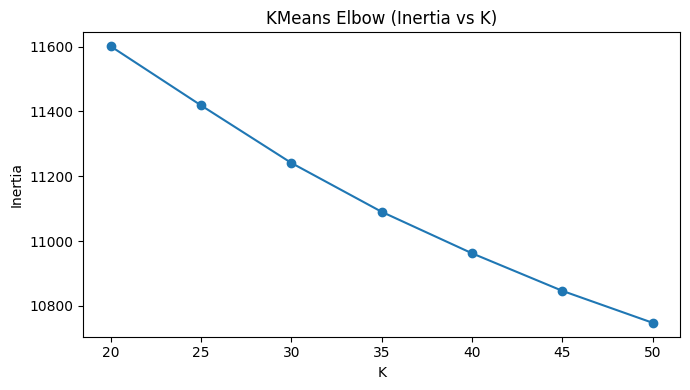

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(Ks, inertias, marker="o")
plt.title("KMeans Elbow (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

Based on the elbow method computed on a random subset of embeddings, K=30 provides a good trade-off between cluster granularity and compactness.

In [41]:
from sklearn.cluster import KMeans

K = 30  # adjust only if your elbow clearly suggests another value

kmeans = KMeans(
    n_clusters=K,
    n_init=5,
    random_state=42
)

labels = kmeans.fit_predict(X)

In [42]:
meta = meta.copy()
meta["cluster"] = labels

meta["cluster"].value_counts().head(10)

cluster
1     7811
3     6189
23    6167
15    5913
26    5743
2     5650
25    5627
19    5264
7     5130
4     4519
Name: count, dtype: int64

In [43]:
meta["cluster"].value_counts().describe()

count      30.000000
mean     4123.333333
std      1634.160046
min       474.000000
25%      3452.500000
50%      4264.500000
75%      5230.500000
max      7811.000000
Name: count, dtype: float64

In [44]:
top_titles_per_cluster = (
    meta.groupby("cluster")["title"]
    .apply(lambda s: s.value_counts().head(5))
)

top_titles_per_cluster.head()

cluster                      
0        Associate Attorney      108
         Paralegal                66
         Attorney                 45
         Legal Assistant          42
         Litigation Associate     39
Name: title, dtype: int64

In [45]:
cluster_labels = (
    top_titles_per_cluster
    .groupby(level=0)
    .apply(lambda s: " | ".join(s.index.get_level_values(1)[:2]))
)

cluster_labels.head()

cluster
0                    Associate Attorney | Paralegal
1       Patient Care Technician | Medical Assistant
2               Product Manager | Account Executive
3       Maintenance Technician | Service Technician
4    Administrative Assistant | Executive Assistant
Name: title, dtype: object

In [46]:
meta["cluster_label"] = meta["cluster"].map(cluster_labels)

meta[["cluster", "cluster_label"]].drop_duplicates().sort_values("cluster").head(10)

,cluster,cluster_label
3,0,Associate Attorney | Paralegal
8,1,Patient Care Technician | Medical Assistant
167,2,Product Manager | Account Executive
4,3,Maintenance Technician | Service Technician
30,4,Administrative Assistant | Executive Assistant
2,5,Restaurant Manager | Cook
85,6,Cyber Security Engineer | Security Officer
39,7,Material Handler | Warehouse Associate
17,8,Store Driver | Automotive Technician
5,9,Sales Associate | Junior Groomer


In [47]:
OUT_DIR = PROJECT_ROOT / "models" / "clusters"
OUT_DIR.mkdir(parents=True, exist_ok=True)

meta.to_parquet(OUT_DIR / "job_postings_with_clusters.parquet", index=False)

In [48]:
if "period" in meta.columns:
    cluster_share = (
        meta.groupby(["period", "cluster"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    cluster_share.head()

In [49]:
if "period" in meta.columns:
    pivot = cluster_share.pivot(
        index="cluster", columns="period", values="share"
    ).fillna(0)

    pivot["delta"] = pivot.get("late_period", 0) - pivot.get("early_period", 0)
    pivot.sort_values("delta", ascending=False).head(10)

In [50]:
cluster_sizes = meta["cluster"].value_counts().sort_index()

top_titles = (
    meta.groupby("cluster")["title"]
    .apply(lambda s: s.value_counts().head(8).index.tolist())
)

summary = pd.DataFrame({
    "size": cluster_sizes,
    "top_titles": top_titles
}).sort_values("size", ascending=False)

summary.head(10)

,size,top_titles
cluster,,
1,7811,"[Patient Care Technician, Medical Assistant, P..."
3,6189,"[Maintenance Technician, Service Technician, A..."
23,6167,"[Software Engineer, Senior Software Engineer, ..."
15,5913,"[Receptionist, Package Handler - Part Time (Wa..."
26,5743,"[Sales Specialist, Outside Sales Representativ..."
2,5650,"[Product Manager, Account Executive, Product O..."
25,5627,"[Electrical Engineer, Mechanical Engineer, Man..."
19,5264,"[Registered Nurse, Certified Nursing Assistant..."
7,5130,"[Material Handler, Warehouse Associate, Wareho..."


In [51]:
summary.head(30)

,size,top_titles
cluster,,
1,7811,"[Patient Care Technician, Medical Assistant, P..."
3,6189,"[Maintenance Technician, Service Technician, A..."
23,6167,"[Software Engineer, Senior Software Engineer, ..."
15,5913,"[Receptionist, Package Handler - Part Time (Wa..."
26,5743,"[Sales Specialist, Outside Sales Representativ..."
2,5650,"[Product Manager, Account Executive, Product O..."
25,5627,"[Electrical Engineer, Mechanical Engineer, Man..."
19,5264,"[Registered Nurse, Certified Nursing Assistant..."
7,5130,"[Material Handler, Warehouse Associate, Wareho..."


In [52]:
import pandas as pd

cluster_summary = (
    meta
    .groupby("cluster")
    .agg(
        size=("cluster", "size"),
        top_titles=("title", lambda s: s.value_counts().head(5).index.tolist())
    )
    .sort_values("size", ascending=False)
)

cluster_summary.head(10)

,size,top_titles
cluster,,
1,7811,"[Patient Care Technician, Medical Assistant, P..."
3,6189,"[Maintenance Technician, Service Technician, A..."
23,6167,"[Software Engineer, Senior Software Engineer, ..."
15,5913,"[Receptionist, Package Handler - Part Time (Wa..."
26,5743,"[Sales Specialist, Outside Sales Representativ..."
2,5650,"[Product Manager, Account Executive, Product O..."
25,5627,"[Electrical Engineer, Mechanical Engineer, Man..."
19,5264,"[Registered Nurse, Certified Nursing Assistant..."
7,5130,"[Material Handler, Warehouse Associate, Wareho..."


In [53]:
cluster_summary["cluster_name"] = cluster_summary["top_titles"].apply(
    lambda lst: " | ".join(lst[:2])
)

cluster_summary[["size", "cluster_name"]].head(10)

,size,cluster_name
cluster,,
1,7811,Patient Care Technician | Medical Assistant
3,6189,Maintenance Technician | Service Technician
23,6167,Software Engineer | Senior Software Engineer
15,5913,Receptionist | Package Handler - Part Time (Wa...
26,5743,Sales Specialist | Outside Sales Representative
2,5650,Product Manager | Account Executive
25,5627,Electrical Engineer | Mechanical Engineer
19,5264,Registered Nurse | Certified Nursing Assistant...
7,5130,Material Handler | Warehouse Associate


In [54]:
if "period" in meta.columns:
    period_share = (
        meta.groupby(["cluster", "period"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    period_pivot = period_share.pivot(
        index="cluster", columns="period", values="share"
    ).fillna(0)

    cluster_summary = cluster_summary.join(period_pivot)

cluster_summary.head(10)

,size,top_titles,cluster_name
cluster,,,
1,7811,"[Patient Care Technician, Medical Assistant, P...",Patient Care Technician | Medical Assistant
3,6189,"[Maintenance Technician, Service Technician, A...",Maintenance Technician | Service Technician
23,6167,"[Software Engineer, Senior Software Engineer, ...",Software Engineer | Senior Software Engineer
15,5913,"[Receptionist, Package Handler - Part Time (Wa...",Receptionist | Package Handler - Part Time (Wa...
26,5743,"[Sales Specialist, Outside Sales Representativ...",Sales Specialist | Outside Sales Representative
2,5650,"[Product Manager, Account Executive, Product O...",Product Manager | Account Executive
25,5627,"[Electrical Engineer, Mechanical Engineer, Man...",Electrical Engineer | Mechanical Engineer
19,5264,"[Registered Nurse, Certified Nursing Assistant...",Registered Nurse | Certified Nursing Assistant...
7,5130,"[Material Handler, Warehouse Associate, Wareho...",Material Handler | Warehouse Associate


In [55]:
c = 1  # change this
cols = ["title", "location", "date"]
if "period" in meta.columns:
    cols.append("period")

meta.loc[meta["cluster"] == c, cols].head(15)

,title,location,date
8,Respiratory Therapist,"Omaha, NE",2024-04-05 20:21:40
46,"Manager, Retail Pharmacy","Tucson, AZ",2024-04-15 19:12:39
61,Front Desk Administrator,"Metairie, LA",2024-04-19 19:22:38
107,Histologist - HT,"Bellingham, WA",2024-04-18 16:36:29
110,Events & Communications Assistant,"Houston, TX",2024-04-15 18:53:26
126,Pharmacy Technician,"Lake County, IL",2024-04-15 19:35:59
173,CT Technologist,"Chattanooga, TN",2024-04-18 20:21:27
188,Primary Care Leader Needed,"Fresno, CA",2024-04-18 17:10:38
192,Ophthalmic Technician,"Fairbanks, AK",2024-04-17 22:26:50
202,Medical Consultant,"Brooklyn, NY",2024-04-18 21:57:31


In [56]:
c = 25  # change this
cols = ["title", "location", "date"]
if "period" in meta.columns:
    cols.append("period")

meta.loc[meta["cluster"] == c, cols].head(15)

,title,location,date
7,Building Engineer,"San Francisco, CA",2024-04-06 22:44:12
13,Structural Engineer,"San Mateo, CA",2024-04-07 03:29:40
23,Sheet Metal Fabricator,"Mineral Wells, TX",2024-04-18 18:25:01
91,Fire Sprinkler Designer,"Brentwood, CA",2024-04-16 15:06:26
135,Motion Graphic Designer and Film Editor,"New York, NY",2024-04-09 12:20:45
180,Sales and Application Engineer,"Louisiana, United States",2024-04-19 14:01:26
183,Drone-Car Engineer,"Trenton, NJ",2024-04-12 01:11:04
195,Senior Mechanical Engineer,"Redwood City, CA",2024-04-12 01:25:31
197,Mechanical Design Engineer,"Cedar Rapids, IA",2024-04-19 14:19:54
212,MEP Engineer,"Lakewood, CO",2024-04-15 20:29:45


In [57]:
# Manual, human-readable cluster labels
cluster_label_map = {
    # meaningful cluster
    25: "Engineering Roles (Electrical & Mechanical)",

    # unclear but accepted cluster
    1: "Clinical Support & Medical Assistant Roles"
}

In [58]:
meta = meta.copy()

meta["cluster_label_manual"] = meta["cluster"].map(cluster_label_map)

# Fallback to automatic label if no manual label exists
meta["cluster_label_final"] = meta["cluster_label_manual"].fillna(meta["cluster_label"])

In [59]:
meta[meta["cluster_label_manual"].notna()][
    ["cluster", "cluster_label", "cluster_label_final"]
].drop_duplicates()

,cluster,cluster_label,cluster_label_final
7,25,Electrical Engineer | Mechanical Engineer,Engineering Roles (Electrical & Mechanical)
8,1,Patient Care Technician | Medical Assistant,Clinical Support & Medical Assistant Roles


In [60]:
OUT_DIR = PROJECT_ROOT / "models" / "clusters"
OUT_DIR.mkdir(parents=True, exist_ok=True)

meta.to_parquet(
    OUT_DIR / "job_postings_with_clusters.parquet",
    index=False
)

print("Saved clustered data with manual labels.")

Saved clustered data with manual labels.


Some clusters exhibit strong semantic coherence and map cleanly to well-defined job families (e.g. Engineering Roles – Electrical & Mechanical).
Other clusters aggregate adjacent roles with overlapping terminology and responsibilities, such as Patient Care Technician and Medical Assistant.
Rather than forcing artificial separation, these clusters are retained and explicitly labeled to reflect real-world job market ambiguity.
This approach prioritizes interpretability and realism over overly granular partitioning.

In [61]:
meta.loc[
    meta["cluster"].isin(cluster_label_map.keys()),
    ["cluster", "cluster_label", "cluster_label_final"]
].drop_duplicates()

,cluster,cluster_label,cluster_label_final
7,25,Electrical Engineer | Mechanical Engineer,Engineering Roles (Electrical & Mechanical)
8,1,Patient Care Technician | Medical Assistant,Clinical Support & Medical Assistant Roles


In [62]:
cluster_stats = (
    meta
    .groupby("cluster_label_final")
    .agg(
        size=("cluster", "size")
    )
    .sort_values("size", ascending=False)
)

cluster_stats.head(10)

,size
cluster_label_final,
Clinical Support & Medical Assistant Roles,7811
Maintenance Technician | Service Technician,6189
Software Engineer | Senior Software Engineer,6167
Receptionist | Package Handler - Part Time (Warehouse like),5913
Sales Specialist | Outside Sales Representative,5743
Product Manager | Account Executive,5650
Engineering Roles (Electrical & Mechanical),5627
Registered Nurse | Certified Nursing Assistant (CNA),5264
Material Handler | Warehouse Associate,5130


In [63]:
if "period" in meta.columns:
    cluster_period = (
        meta
        .groupby(["cluster_label_final", "period"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    cluster_period.head()

In [64]:
if "period" in meta.columns:
    cluster_period = (
        meta
        .groupby(["cluster_label_final", "period"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    pivot = cluster_period.pivot(
        index="cluster_label_final",
        columns="period",
        values="share"
    ).fillna(0)

    pivot["delta_share"] = (
        pivot.get("late_period", 0) - pivot.get("early_period", 0)
    )

    pivot = pivot.sort_values("delta_share", ascending=False)

In [65]:
meta.columns.tolist()

['title',
 'location',
 'date',
 'cluster',
 'cluster_label',
 'cluster_label_manual',
 'cluster_label_final']

In [66]:
import pandas as pd

# Ensure date is datetime
meta = meta.copy()
meta["date"] = pd.to_datetime(meta["date"], errors="coerce")

# Drop rows without a valid date (rare but possible)
meta = meta.dropna(subset=["date"])

# Split by midpoint date
split_date = meta["date"].min() + (meta["date"].max() - meta["date"].min()) / 2
meta["period"] = meta["date"].apply(lambda d: "early_period" if d <= split_date else "late_period")

print("Split date:", split_date)
meta["period"].value_counts()

Split date: 2024-04-06 23:08:35


period
late_period     110888
early_period     12812
Name: count, dtype: int64

In [67]:
# cluster share within each period (normalized)
cluster_period = (
    meta.groupby("period")["cluster_label_final"]
    .value_counts(normalize=True)
    .rename("share")
    .reset_index()
)

cluster_period.head()

,period,cluster_label_final,share
0,early_period,Registered Nurse | Certified Nursing Assistant...,0.081252
1,early_period,Clinical Support & Medical Assistant Roles,0.062832
2,early_period,Registered Nurse - RN - LTAC | Nurse Practitioner,0.057524
3,early_period,Maintenance Technician | Service Technician,0.048938
4,early_period,ASSISTANT STORE MANAGER | Customer Service Rep...,0.046285


In [68]:
pivot = (
    cluster_period
    .pivot(index="cluster_label_final", columns="period", values="share")
    .fillna(0)
)

pivot["delta_share"] = pivot["late_period"] - pivot["early_period"]
pivot = pivot.sort_values("delta_share", ascending=False)

pivot.head(10)

period,early_period,late_period,delta_share
cluster_label_final,,,
Software Engineer | Senior Software Engineer,0.031767,0.051944,0.020177
Engineering Roles (Electrical & Mechanical),0.036606,0.046515,0.009909
Project Manager | Senior Project Manager,0.024430,0.033448,0.009018
Network Engineer | Technical Support Specialist,0.022323,0.030725,0.008402
Sales Specialist | Outside Sales Representative,0.039650,0.047210,0.007559
Product Manager | Account Executive,0.039416,0.046398,0.006982
Data Analyst | Business Analyst,0.024742,0.031572,0.006830
Cyber Security Engineer | Security Officer,0.015845,0.022581,0.006737
Marketing Manager | Graphic Designer,0.022245,0.027983,0.005738


In [69]:
top_rising = pivot.head(5)
top_declining = pivot.tail(5)

top_rising, top_declining

(period                                           early_period  late_period  \
 cluster_label_final                                                          
 Software Engineer | Senior Software Engineer         0.031767     0.051944   
 Engineering Roles (Electrical & Mechanical)          0.036606     0.046515   
 Project Manager | Senior Project Manager             0.024430     0.033448   
 Network Engineer | Technical Support Specialist      0.022323     0.030725   
 Sales Specialist | Outside Sales Representative      0.039650     0.047210   
 
 period                                           delta_share  
 cluster_label_final                                           
 Software Engineer | Senior Software Engineer        0.020177  
 Engineering Roles (Electrical & Mechanical)         0.009909  
 Project Manager | Senior Project Manager            0.009018  
 Network Engineer | Technical Support Specialist     0.008402  
 Sales Specialist | Outside Sales Representative     0.007559

In [70]:
cluster_period.columns.tolist()

['period', 'cluster_label_final', 'share']

Over the observed two-month window, cluster share shifted noticeably across job families. Software engineering roles increased the most in relative share (+2.02pp), followed by electrical/mechanical engineering (+0.99pp), project management (+0.90pp), and network/technical support (+0.84pp). Commercial roles also showed a modest rise, with outside sales increasing by +0.76pp. On the declining side, healthcare support clusters dropped sharply, with RN/CNA-related postings decreasing by −4.32pp and RN/LTAC–NP roles by −2.97pp. Several retail and business development clusters also decreased by around one percentage point. Given the short time horizon, these movements should be interpreted as short-window shifts in posting composition rather than long-term labor market trends, but they demonstrate how semantic clustering enables interpretable monitoring at the job-family level.

In [71]:
for label in list(top_rising.index[:2]) + list(top_declining.index[:2]):
    print("\nCLUSTER:", label)
    print(meta.loc[meta["cluster_label_final"] == label, "title"].value_counts().head(10))


CLUSTER: Software Engineer | Senior Software Engineer
title
Software Engineer           150
Senior Software Engineer    122
Software Developer           55
DevOps Engineer              55
Frontend Developer           54
Back End Developer           51
Full Stack Engineer          50
Web Developer                39
Python Developer             36
Java Developer               34
Name: count, dtype: int64

CLUSTER: Engineering Roles (Electrical & Mechanical)
title
Electrical Engineer           121
Mechanical Engineer            78
Manufacturing Engineer         77
Process Engineer               56
Quality Engineer               43
Project Engineer               41
Structural Engineer            40
Senior Mechanical Engineer     38
Design Engineer                36
Senior Electrical Engineer     36
Name: count, dtype: int64

CLUSTER: Sales Associate | Junior Groomer
title
Sales Associate               59
Junior Groomer                28
Groomer                       27
Property Manager   

In [77]:
signal_table = (
    pivot
    .reset_index()
    .rename(columns={"cluster_label_final": "Job Family"})
)

signal_table

period,Job Family,early_period,late_period,delta_share
0,Software Engineer | Senior Software Engineer,0.031767,0.051944,0.020177
1,Engineering Roles (Electrical & Mechanical),0.036606,0.046515,0.009909
2,Project Manager | Senior Project Manager,0.024430,0.033448,0.009018
3,Network Engineer | Technical Support Specialist,0.022323,0.030725,0.008402
4,Sales Specialist | Outside Sales Representative,0.039650,0.047210,0.007559
5,Product Manager | Account Executive,0.039416,0.046398,0.006982
6,Data Analyst | Business Analyst,0.024742,0.031572,0.006830
7,Cyber Security Engineer | Security Officer,0.015845,0.022581,0.006737
8,Marketing Manager | Graphic Designer,0.022245,0.027983,0.005738
9,Financial Advisor | Mortgage Loan Officer,0.030674,0.035919,0.005245


In [78]:
signal_summary = pd.concat([
    signal_table.head(5).assign(signal="Rising"),
    signal_table.tail(5).assign(signal="Declining")
])

signal_summary

period,Job Family,early_period,late_period,delta_share,signal
0,Software Engineer | Senior Software Engineer,0.031767,0.051944,0.020177,Rising
1,Engineering Roles (Electrical & Mechanical),0.036606,0.046515,0.009909,Rising
2,Project Manager | Senior Project Manager,0.024430,0.033448,0.009018,Rising
3,Network Engineer | Technical Support Specialist,0.022323,0.030725,0.008402,Rising
4,Sales Specialist | Outside Sales Representative,0.039650,0.047210,0.007559,Rising
25,Sales Associate | Junior Groomer,0.042304,0.035450,-0.006854,Declining
26,ASSISTANT STORE MANAGER | Customer Service Rep...,0.046285,0.034819,-0.011466,Declining
27,Sales Manager | Business Development Manager,0.015298,0.003625,-0.011673,Declining
28,Registered Nurse - RN - LTAC | Nurse Practitioner,0.057524,0.027785,-0.029739,Declining
29,Registered Nurse | Certified Nursing Assistant...,0.081252,0.038083,-0.043168,Declining


In [84]:
DOCS_DIR = PROJECT_ROOT / "docs"
DOCS_DIR.mkdir(exist_ok=True)

signal_summary_rounded.to_csv(
    DOCS_DIR / "top_rising_declining_clusters.csv",
    index=False
)

In [85]:
(DOCS_DIR / "top_rising_declining_clusters.csv").exists()

True

In [86]:
import pandas as pd

plot_df = (
    pivot[["delta_share"]]
    .reset_index()
    .rename(columns={"cluster_label_final": "Job Family"})
)

plot_df.head()

period,Job Family,delta_share
0,Software Engineer | Senior Software Engineer,0.020177
1,Engineering Roles (Electrical & Mechanical),0.009909
2,Project Manager | Senior Project Manager,0.009018
3,Network Engineer | Technical Support Specialist,0.008402
4,Sales Specialist | Outside Sales Representative,0.007559


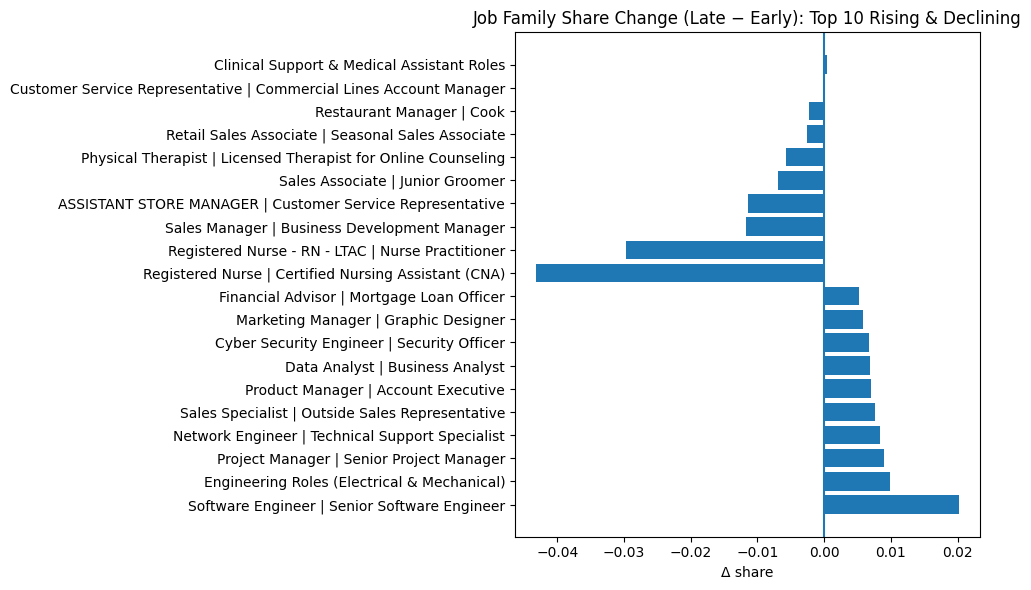

In [87]:
import matplotlib.pyplot as plt

TOP_N = 10

top_rise = plot_df.nlargest(TOP_N, "delta_share")
top_fall = plot_df.nsmallest(TOP_N, "delta_share")
plot_top = pd.concat([top_rise, top_fall], axis=0)

plt.figure(figsize=(10, 6))
plt.barh(plot_top["Job Family"], plot_top["delta_share"])
plt.axvline(0)
plt.title(f"Job Family Share Change (Late − Early): Top {TOP_N} Rising & Declining")
plt.xlabel("Δ share")
plt.ylabel("")
plt.tight_layout()
plt.show()

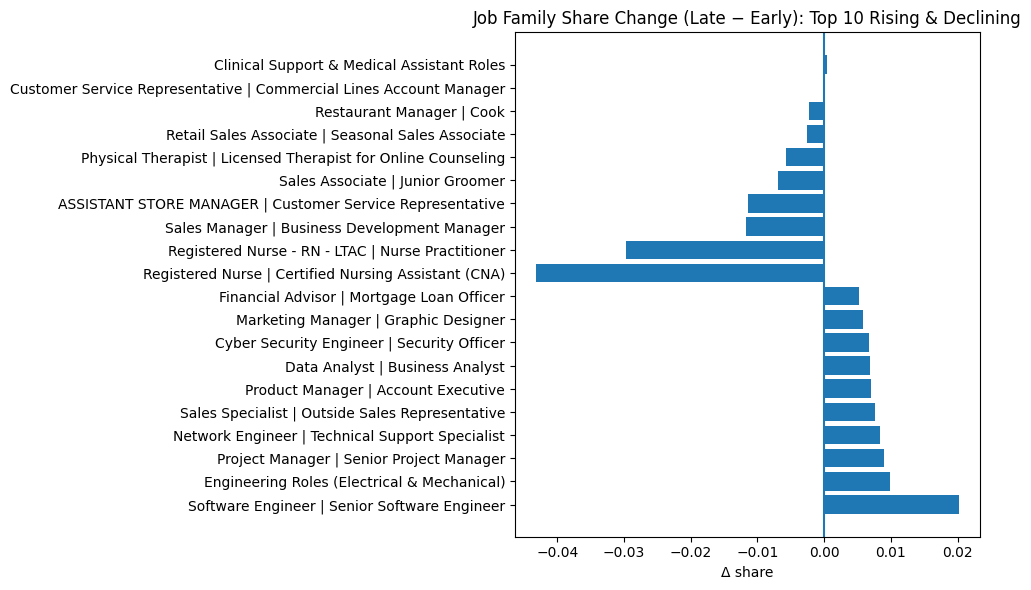

Saved: /Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/docs/img/delta_share_top_movers.png


In [88]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  # if notebook is in /notebooks
IMG_DIR = PROJECT_ROOT / "docs" / "img"
IMG_DIR.mkdir(parents=True, exist_ok=True)

out_path = IMG_DIR / "delta_share_top_movers.png"
plt.figure(figsize=(10, 6))
plt.barh(plot_top["Job Family"], plot_top["delta_share"])
plt.axvline(0)
plt.title(f"Job Family Share Change (Late − Early): Top {TOP_N} Rising & Declining")
plt.xlabel("Δ share")
plt.ylabel("")
plt.tight_layout()
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path)